In [ ]:
!pip install -q tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import librosa
import librosa.display

from tensorflow.keras import layers, models
import tensorflow as tf

import tempfile
import zipfile
import time

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
# TF Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/donateacry_corpus_cleaned_and_updated_data/"
folder_crycelab2023 = "/content/drive/My Drive/CryCeLab2023/"
folder_ESC50 = "/content/drive/My Drive/ESC-50/"

Mounted at /content/drive


In [ ]:
def wav_to_spectrogram(file_path, output_shape=(128, 64)):
    # Load the WAV file
    y, sr = librosa.load(file_path, sr=8000, dtype=np.float32)
    # print(sr)

    # Generate the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    tmp = spectrogram.shape
    # Resize the spectrogram so that it can be fed into the model
    spectrogram = librosa.util.fix_length(spectrogram, size=output_shape[1], mode='constant', constant_values=0)

    # Normalize the spectrogram to values between 0 and 1, this really helps improve model accuracy
    spectrogram = librosa.util.normalize(spectrogram)

    return spectrogram, sr, y, tmp




# **457 Cleaned data**

In [ ]:
shape = []
# Define the folder containing the subfolders with WAV files
data_folder = folder_path
# Define the labels (subfolder names)
labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize empty lists to store spectrograms and labels
X0 = []
y0_model1 = []
y0_model2 = []

# Iterate through the labels
for label_idx, label in enumerate(labels):
    label_folder = os.path.join(data_folder, label)

    # Iterate through WAV files in the label folder
    for wav_file in os.listdir(label_folder):
        if wav_file.endswith('.wav'):
            wav_file_path = os.path.join(label_folder, wav_file)

            # Convert WAV to spectrogram using the wav_to_spectrogram function
            spectrogram, sr, au, tmp = wav_to_spectrogram(wav_file_path)

            shape.append(tmp[1])
            # Append the spectrogram to X_train
            X0.append(spectrogram)

            # Append the label index (numeric representation of the label) to y_train
            y0_model1.append(1)
            y0_model2.append(label_idx)

# Convert lists to NumPy arrays for further processing
X = np.array(X0)
y0_model1 = np.array(y0_model1)
y0_model2 = np.array(y0_model2)

# Check the shapes
print(f'X shape: {X.shape}')
print(f'y shape: {y0_model1.shape}')

X shape: (457, 128, 64)
y shape: (457,)


In [ ]:
# min(shape),shape

# **~1000 all baby cry data**

In [ ]:
data_folder1 = folder_path + 'All Data'
label_old = {'hu': 0, 'bu': 0, 'bp': 0, 'dc': 0, 'ti': 0, 'lo': 0, 'ch': 0, 'sc': 0, 'dk': 0}

# Initialize empty lists to store spectrograms and labels
X1 = []
y1_model1, y1_model2 = [], []
for wav_file in os.listdir(data_folder1):
        if wav_file.endswith('.3gp') or wav_file.endswith('.caf'):
            wav_file_path = os.path.join(data_folder1, wav_file)
            # lb = wav_file_path[]
            if wav_file[-6:-4] not in label_old.keys(): continue
            label_old[wav_file[-6:-4]] += 1
            # Convert WAV to spectrogram using the wav_to_spectrogram function
            spectrogram, sr, au, tmp = wav_to_spectrogram(wav_file_path)

            # Append the spectrogram to X_train
            X1.append(spectrogram)

            # Append the label index (numeric representation of the label) to y_train
            y1_model1.append(1)

            label_idx = 0
            if wav_file[-6:-4] == 'bp': label_idx = 0
            elif wav_file[-6:-4] == "bu": label_idx = 1
            elif wav_file[-6:-4] == "dc": label_idx = 2
            elif wav_file[-6:-4] == "hu": label_idx = 3
            elif wav_file[-6:-4] == "ti": label_idx = 4

            y1_model2.append(label_idx)

# Convert lists to NumPy arrays for further processing
X1 = np.array(X1)
y1_model1 = np.array(y1_model1)
y1_model2 = np.array(y1_model2)
# Check the shapes
print(f'X shape: {X1.shape}')
print(f'y shape: {y1_model2.shape}')

X shape: (1126, 128, 64)
y shape: (1126,)


In [ ]:
#check duplicates

old_files = os.listdir(data_folder1)

clean_files = []
for label_idx, label in enumerate(labels):
    label_folder = os.path.join(data_folder, label)
    # Iterate through WAV files in the label folder
    clean_files.extend(os.listdir(label_folder))


set(old_files)&set(clean_files)
'7b23d26e-6f97-4e8b-b520-a9fdde21ee91-1432275312750-1.7-m-48-hu.wav' in old_files

False

# **~20k cryceleb2023**

In [ ]:
data_folder2 = folder_crycelab2023 + 'audio/dev/'
limit = 2000
# Initialize empty lists to store spectrograms and labels
X2 = []
y2_model1 = []
count = 0
for subfolder in os.listdir(data_folder2):
  if os.path.isdir(os.path.join(data_folder2,subfolder)):
    for subsubfolder in os.listdir(os.path.join(data_folder2,subfolder)):
      if os.path.isdir(os.path.join(data_folder2,subfolder, subsubfolder)):
        for wav_file in os.listdir(os.path.join(data_folder2,subfolder,subsubfolder)):
          if wav_file.endswith('.wav'):
              wav_file_path = os.path.join(data_folder2,subfolder,subsubfolder, wav_file)
              # Convert WAV to spectrogram using the wav_to_spectrogram function
              spectrogram, sr, au, tmp = wav_to_spectrogram(wav_file_path)
              shape.append(tmp[1])
              # Append the spectrogram to X_train
              X2.append(spectrogram)

              # Append the label index (numeric representation of the label) to y_train
              y2_model1.append(1)
              count += 1
          if count == limit:
            break
      if count == limit:
        break
  if count == limit:
    break

# Convert lists to NumPy arrays for further processing
X2 = np.array(X2)
y2_model1 = np.array(y2_model1)

# Check the shapes
print(f'X shape: {X2.shape}')
print(f'y shape: {y2_model1.shape}')

X shape: (1614, 128, 64)
y shape: (1614,)


In [ ]:
X2.shape

(1614, 128, 64)

In [ ]:
label_esc50 = pd.read_csv(folder_ESC50 + 'ESC-50-master/meta/esc50.csv')
label_esc50

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
esc50_cry_files = label_esc50.loc[label_esc50['category'] == 'crying_baby', 'filename'].values; esc50_cry_files

array(['1-187207-A-20.wav', '1-211527-A-20.wav', '1-211527-B-20.wav',
       '1-211527-C-20.wav', '1-22694-A-20.wav', '1-22694-B-20.wav',
       '1-60997-A-20.wav', '1-60997-B-20.wav', '2-107351-A-20.wav',
       '2-107351-B-20.wav', '2-151079-A-20.wav', '2-50665-A-20.wav',
       '2-50666-A-20.wav', '2-66637-A-20.wav', '2-66637-B-20.wav',
       '2-80482-A-20.wav', '3-151080-A-20.wav', '3-151081-A-20.wav',
       '3-151081-B-20.wav', '3-152007-A-20.wav', '3-152007-B-20.wav',
       '3-152007-C-20.wav', '3-152007-D-20.wav', '3-152007-E-20.wav',
       '4-167077-A-20.wav', '4-167077-B-20.wav', '4-167077-C-20.wav',
       '4-185575-A-20.wav', '4-185575-B-20.wav', '4-185575-C-20.wav',
       '4-59579-A-20.wav', '4-59579-B-20.wav', '5-151085-A-20.wav',
       '5-198411-A-20.wav', '5-198411-B-20.wav', '5-198411-C-20.wav',
       '5-198411-D-20.wav', '5-198411-E-20.wav', '5-198411-F-20.wav',
       '5-198411-G-20.wav'], dtype=object)

In [ ]:
data_folder3 = folder_ESC50 + 'ESC-50-master/audio'

# Initialize empty lists to store spectrograms and labels
X3 = []
y3_model1 = []
for wav_file in os.listdir(data_folder3):
        if wav_file.endswith('.wav'):
            wav_file_path = os.path.join(data_folder3, wav_file)

            # Convert WAV to spectrogram using the wav_to_spectrogram function
            spectrogram, sr, au, tmp = wav_to_spectrogram(wav_file_path)

            shape.append(tmp[1])
            # Append the spectrogram to X_train
            X3.append(spectrogram)

            # Append the label index (numeric representation of the label) to y_train
            if wav_file in esc50_cry_files: y3_model1.append(1)
            else: y3_model1.append(0)

# Convert lists to NumPy arrays for further processing
X3 = np.array(X3)
y3_model1 = np.array(y3_model1)

# Check the shapes
print(f'X shape: {X3.shape}')
print(f'y shape: {y3_model1.shape}')

X shape: (2000, 128, 64)
y shape: (2000,)


In [ ]:
sum(y3_model1 == 1)

40


# **CREMA-D**

In [ ]:
import os
import subprocess

# Define the GitHub repository URL
github_repo_url = "https://github.com/CheyneyComputerScience/CREMA-D.git"

# Clone the repository
subprocess.run(["git", "clone", github_repo_url])

# Define the path to the cloned repository
repo_path = "CREMA-D"

In [ ]:
X4 = []
y4_model1 = []

# Initialize empty lists to store WAV file paths and folder names
wav_files = []
folder_names = []

# Walk through the directory structure to find WAV files and their folders
for root, dirs, files in os.walk(repo_path):
    for file in files:
        # if file.endswith(".wav"):
        if file.endswith(".wav"):
            # Get the full path of the WAV file
            wav_path = os.path.join(root, file)

            # Extract the folder name from the path
            folder_name = os.path.basename(root)

            # Append the WAV file path and folder name to the respective lists
            wav_files.append(wav_path)

            spectrogram, sr, au, tmp = wav_to_spectrogram(wav_path)

            shape.append(tmp[1])
            # Append the spectrogram to X_train
            X4.append(spectrogram)

            # Append the label index (numeric representation of the label) to y_train
            y4_model1.append(0)

# Convert lists to NumPy arrays for further processing
X4 = np.array(X4)
y4_model1 = np.array(y4_model1)

# Check the shapes
print(f'X shape: {X4.shape}')
print(f'y shape: {y4_model1.shape}')

X shape: (7442, 128, 64)
y shape: (7442,)


# **Concat data**


In [ ]:
x_final_model1 = np.concatenate((X0, X1, X2,X3, X4), axis  = 0)
# x_final_model1 = np.concatenate((X0, X2, X3, X4), axis  = 0)
x_final_model1.shape

(12639, 128, 64)

In [ ]:
y_final_model1 = np.concatenate((y0_model1, y1_model1, y2_model1,y3_model1, y4_model1), axis  = 0)
# y_final_model1 = np.concatenate((y0_model1, y2_model1, y3_model1, y4_model1), axis  = 0)
y_final_model1.shape

(12639,)

In [ ]:
x_final_model2 = np.concatenate((X0, X1), axis  = 0)
x_final_model2.shape

(1583, 128, 64)

In [ ]:
y_final_model2 = np.concatenate((y0_model2, y1_model2), axis  = 0)
y_final_model2.shape

(1583,)

In [ ]:
np.save('y_final_model2.npy', y_final_model2)
np.save('x_final_model2.npy', x_final_model2)

In [ ]:
y_final_model1, y_final_model2

(array([1, 1, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 3, 0, 3]))

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x_final_model1, y_final_model1, test_size=0.10, random_state=215)

In [ ]:
!ls

CREMA-D  drive	qkeras	sample_data  x_final_model2.npy  y_final_model2.npy


In [ ]:
folder_out = "/content/drive/My Drive/Xy_data/"

In [ ]:
np.save('X_model1.npy',  x_final_model1)

In [ ]:
np.save('./X_model2.npy',  x_final_model2)

In [ ]:
np.save('./y_model1.npy',  y_final_model1)

In [ ]:
np.save('./y_model2.npy',  y_final_model2)

In [ ]:
# Create the model
num_classes = len(np.unique(y_train))
x_shape = X[0].shape

model = models.Sequential([
    layers.Input(shape=(x_shape[0], x_shape[1])),  # Adjust the input shape based on your spectrogram size
    layers.Reshape(target_shape=(x_shape[0], x_shape[1], 1)),  # Add a channel dimension
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(x_shape[0], activation='relu'),
    layers.Dense(num_classes, activation='softmax') #sigmoid
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Convert labels to one-hot encoding (assuming you have more than one class)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

# Train the model
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/10
292/292 [==============================] - 77s 261ms/step - loss: 0.0888 - accuracy: 0.9648 - val_loss: 0.0660 - val_accuracy: 0.9711
Epoch 2/10
292/292 [==============================] - 71s 245ms/step - loss: 0.0277 - accuracy: 0.9898 - val_loss: 0.0618 - val_accuracy: 0.9749
Epoch 3/10
292/292 [==============================] - 71s 242ms/step - loss: 0.0083 - accuracy: 0.9974 - val_loss: 0.0826 - val_accuracy: 0.9759
Epoch 4/10
292/292 [==============================] - 73s 249ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0865 - val_accuracy: 0.9730
Epoch 5/10
292/292 [==============================] - 70s 241ms/step - loss: 6.9717e-04 - accuracy: 0.9999 - val_loss: 0.1019 - val_accuracy: 0.9769
Epoch 6/10
292/292 [==============================] - 67s 231ms/step - loss: 2.6496e-04 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9749
Epoch 7/10
292/292 [==============================] - 71s 242ms/step - loss: 1.3770e-04 - accuracy: 1.0000 - val_loss: 0.1

## Model Pruning

### Analyze Model weights and size

In [ ]:
def check_model_weights(model):
  for i, w in enumerate(model.get_weights()):
    print(model.weights[i].name,"Total:",w.size, "Zeros:", round(np.sum(np.abs(w) <= 0.0001) / w.size * 100,6),"%")

check_model_weights(model)

conv2d/kernel:0 Total: 288 Zeros: 0.0 %
conv2d/bias:0 Total: 32 Zeros: 0.0 %
dense/kernel:0 Total: 7999488 Zeros: 0.668343 %
dense/bias:0 Total: 128 Zeros: 1.5625 %
dense_1/kernel:0 Total: 256 Zeros: 0.390625 %
dense_1/bias:0 Total: 2 Zeros: 0.0 %


In [ ]:
def compare_model_sizes(model):
  _, model_file = tempfile.mkstemp(".h5")
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
  # Zip the .h5 model file
  _, zip3 = tempfile.mkstemp(".zip")
  with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
      f.write(model_file)
  print("Model before zip: %.2f Kb"% (os.path.getsize(model_file) / float(1000)))
  print("Model after zip: %.2f Kb"% (os.path.getsize(zip3) / float(1000)))

compare_model_sizes(model)

Model before zip: 32020.42 Kb
Model after zip: 29702.04 Kb


### Model Prune

In [ ]:
# Define model for pruning
epochs = 5
end_step = np.ceil(len(X_train) / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(model, **pruning_params)

# Optimizer
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Compile
model_for_pruning.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()

# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()

history = model_for_pruning.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks, verbose=1)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Evaluate the model on the test set
y_pred = model_for_pruning.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Test accuracy: {accuracy:.2f}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshap  (None, 128, 64, 1)        1         
 e (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d  (None, 126, 62, 32)       610       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 63, 31, 32)        1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_flatte  (None, 62496)             1         
 n (PruneLowMagnitude)                                           
                                                        

### Analyze Pruned Weights

In [ ]:
# Get the model back after pruning
after_prune = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
after_prune.summary()

check_model_weights(after_prune)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 64, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 126, 62, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 31, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 62496)             0         
                                                                 
 dense (Dense)               (None, 128)               7999616   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

### Model Size after Pruning

In [ ]:
compare_model_sizes(after_prune)

Model before zip: 32020.42 Kb
Model after zip: 9231.73 Kb


## Custom Tests

In [ ]:
# Try Customized Test
# Test labels: [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]

folder_test = "/content/drive/My Drive/custom_test/"

In [ ]:
# Initialize empty lists to store spectrograms and labels
Xtest = []
ytest = []
filename = []
for wav_file in os.listdir(folder_test):
        # print(wav_file)
        if wav_file.endswith('.wav'):
            wav_file_path = os.path.join(folder_test, wav_file)
            spectrogram, sr, au, tmp = wav_to_spectrogram(wav_file_path)

            # Append the spectrogram to X_train
            Xtest.append(spectrogram)
            filename.append(wav_file)
            # Append the label index (numeric representation of the label) to y_train
            ytest.append(1)

# Convert lists to NumPy arrays for further processing
Xtest = np.array(Xtest)
ytest = np.array(ytest)

# Check the shapes
print(f'X shape: {Xtest.shape}')
print(f'y shape: {ytest.shape}')

In [ ]:
# True labels: [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]
ypred = model.predict(Xtest)
ypred_classes = np.argmax(ypred, axis=1)
ypred_classes, ypred

1/1 [==============================] - 0s 136ms/step


(array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 array([[9.1212624e-01, 8.7873638e-02],
        [9.9973178e-01, 2.6826462e-04],
        [9.9999994e-01, 6.7306266e-10],
        [2.0896146e-01, 7.9103857e-01],
        [8.4596211e-01, 1.5403786e-01],
        [9.9999994e-01, 6.0493011e-21],
        [9.9985790e-01, 1.4216064e-04],
        [9.9999994e-01, 2.6409555e-13],
        [1.0000000e+00, 1.4125071e-10],
        [1.0000000e+00, 2.7305738e-17],
        [9.9999571e-01, 4.2798210e-06]], dtype=float32))

In [ ]:
ypred = model_for_pruning.predict(Xtest)
ypred_classes = np.argmax(ypred, axis=1)
ypred_classes, filename

NameError: ignored

In [ ]:
# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
validation_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))

In [ ]:
history = model.fit(train_data.batch(3), epochs=epochs, validation_data=validation_data.batch(1),)

Epoch 1/5
1559/1559 [==============================] - 249s 160ms/step - loss: 0.0338 - accuracy: 0.9902 - val_loss: 0.2130 - val_accuracy: 0.9231
Epoch 2/5
1559/1559 [==============================] - 276s 177ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.4269 - val_accuracy: 0.9000
Epoch 3/5
1559/1559 [==============================] - 263s 169ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3880 - val_accuracy: 0.9327
Epoch 4/5
1559/1559 [==============================] - 292s 187ms/step - loss: 2.0722e-04 - accuracy: 1.0000 - val_loss: 0.4293 - val_accuracy: 0.9327
Epoch 5/5
1559/1559 [==============================] - 241s 155ms/step - loss: 7.5784e-05 - accuracy: 1.0000 - val_loss: 0.4703 - val_accuracy: 0.9327


In [ ]:
train_data.batch(3), X_train.shape, y_train_encoded.shape

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>,
 (4677, 128, 64),
 (4677, 2))

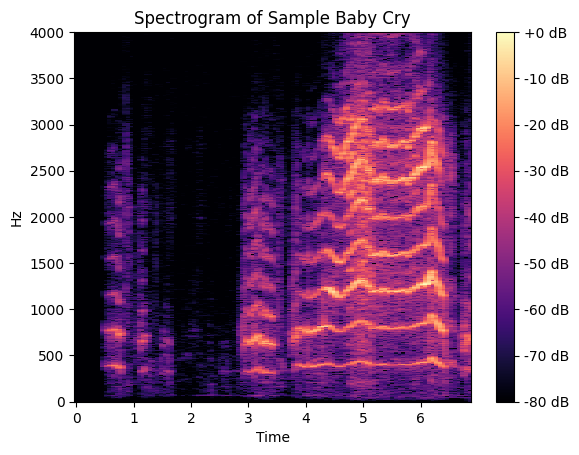

In [ ]:
spectrogram, sr, y, tmp = wav_to_spectrogram(folder_path + 'belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav')
D = librosa.stft(y)  #  short-time Fourier transform of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr=sr)
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.set(title='Spectrogram of Sample Baby Cry');

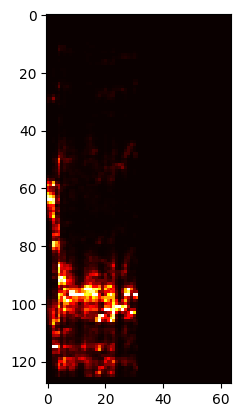

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(X2[3], cmap='hot', interpolation='nearest')
plt.show()

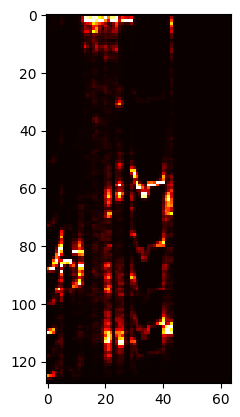

In [ ]:
plt.imshow(Xtest[7], cmap='hot', interpolation='nearest')
plt.show()

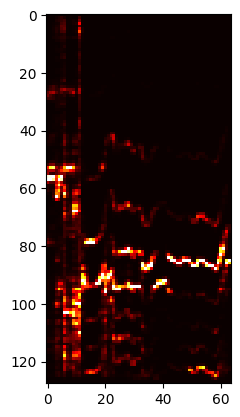

In [ ]:
plt.imshow(Xtest[3], cmap='hot', interpolation='nearest')
plt.show()